In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
import random

warnings.filterwarnings('ignore')

In [2]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# encoding letters to integers
charset = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(charset)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Creating the dataset 

def build_dataset(words):
    block_size = 3
    X = []
    Y = []
    for w in words:
        context = [0]*block_size 
        # print(w)
        for char in w + '.':
            X.append(context)
            Y.append(stoi[char])
            # print(f'{[itos[i] for i in context]} --> {char}')
            context = context[1:] + [stoi[char]]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y 

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
XDev, YDev = build_dataset(words[n1:n2])
Xts, Yts  = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# initializing Parameters
block_size = 3
vocab_size = len(itos)
n_emb = 10
n_hidden = 200
b = (5/3) / ((n_emb*block_size)**0.5)
g = torch.Generator().manual_seed(220) 
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * b
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) 

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

num_parameters = sum(p.nelement() for p in parameters)
num_parameters

12097

In [6]:
# tracking stats
lossi = []

In [7]:
# Training 
epochs = 200000

for i in range(epochs):

    #creating a batch of 32
    ix = torch.randint(0, Xtr.shape[0], (64,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @  W1 # First hidden layer with 200 neurons
    
    #batch normalization
    # ------------------------------------------
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True) 
    hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani 
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 
    # ----------------------------------------------    
    
    h = torch.tanh(hpreact) # activations of the first hidden layer
    logits = h @ W2 + b2 # Output layer with 27 neurons predicting probability for each letter
    loss = F.cross_entropy(logits, Yb)
    
    # backward
    for p in parameters:
        p.grad = None
    loss.backward() 
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    
    if i % 10000 == 0:
        lossi.append(loss.item())
        print(f'{i} / {epochs} : {loss.item():.4f}')

    # break

0 / 200000 : 3.2931
10000 / 200000 : 1.9200
20000 / 200000 : 2.0506
30000 / 200000 : 2.0510
40000 / 200000 : 2.1867
50000 / 200000 : 2.1866
60000 / 200000 : 2.0826
70000 / 200000 : 2.0093
80000 / 200000 : 2.3824
90000 / 200000 : 2.1027
100000 / 200000 : 2.1838
110000 / 200000 : 2.3766
120000 / 200000 : 1.8547
130000 / 200000 : 1.8204
140000 / 200000 : 2.0994
150000 / 200000 : 2.2272
160000 / 200000 : 2.1095
170000 / 200000 : 1.9844
180000 / 200000 : 2.1057
190000 / 200000 : 2.2860


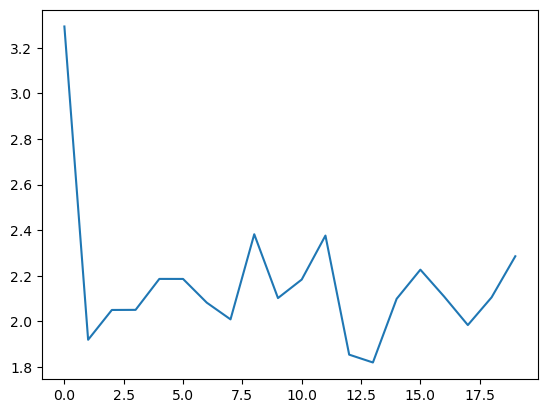

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad()
def split_loss(split):
    X, Y = {'train': (Xtr, Ytr),
            'dev' : (XDev, YDev),
            'test' : (Xts, Yts)}[split]
    emb = C[X]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1
    hpreact = bngain*(hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    print(split, loss.item())

split_loss('dev')
split_loss('train')

dev 2.0993874073028564
train 2.0437543392181396


In [11]:
# inference from the model
g = torch.Generator().manual_seed(220 + 10)
for _ in range(10):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        
        hpreact = embcat @ W1
        hpreact = bngain*(hpreact - bnmean_running) / bnstd_running + bnbias
        
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2  
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

lee.
kynleykan.
zaysenkowa.
bin.
vion.
lenniyland.
taleah.
wesley.
kani.
mikka.


In [12]:
# ---------------------------------------- SUMMMARY --------------------------------------------------

In [5]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 
        self.bias = torch.randn(fan_out, generator=g) if bias else None 

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias 

        return self.out 

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) 

In [34]:
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum 
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers updated with running momentum 
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) 

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)

        else:
            xmean = self.running_mean 
            xvar = self.running_var 

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) 
        self.out = self.gamma * xhat + self.beta 

        if self.training:
            self.running_mean = (1. - self.momentum) * self.running_mean + self.momentum*xmean 
            self.running_var = (1. - self.momentum) * self.running_var + self.momentum*xvar

        return self.out 

    def parameters(self):
        return [self.gamma, self.beta] 

In [35]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [36]:
n_emb = 10
n_hidden = 100 
vocab_size = len(itos)
block_size = 3
g = torch.Generator().manual_seed(220) 

C = torch.randn((vocab_size, n_emb), generator=g)

Layers = [ 
    Linear(block_size*n_emb, n_hidden),BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)    
]

with torch.no_grad():
    Layers[-1].gamma *= 0.1
    # last layer make less confident
    # Layers[-1].weight *= 0.1

    # apply gain to all layers 
    for layer in Layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3 

parameters = [C] + [p for layer in Layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
    p.requires_grad=True

47551


In [37]:
# optimization 
epochs = 200000
batch_size = 32
lossi = [] 
ud = []

for i in range(epochs):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    xb, yb = Xtr[ix], Ytr[ix] 

    # Forward pass 
    emb = C[xb]
    x = emb.view(emb.shape[0], -1)
    for layer in Layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)

    # Backward pass 
    for layer in Layers:
        # print(layer.__class__.__name__)
        layer.out.retain_grad() # after debug take out retain graph 
    for p in parameters:
        p.grad = None
    loss.backward() 

    # update 
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr*p.grad 

    # track stats 
    if i % 10000 == 0:
        print(f'{i:7d} / {epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # keeps a track of how large the updates are as compared to the actual values in parameters 
    if i >= 1000:
        break 

      0 /  200000: 3.3139


layer 2 (      Tanh) : mean+0.00, std 0.62, saturated 3.66%
layer 5 (      Tanh) : mean-0.00, std 0.63, saturated 3.03%
layer 8 (      Tanh) : mean+0.01, std 0.64, saturated 2.44%
layer 11 (      Tanh) : mean-0.01, std 0.65, saturated 2.22%
layer 14 (      Tanh) : mean+0.01, std 0.65, saturated 2.09%


Text(0.5, 1.0, 'activation distribution')

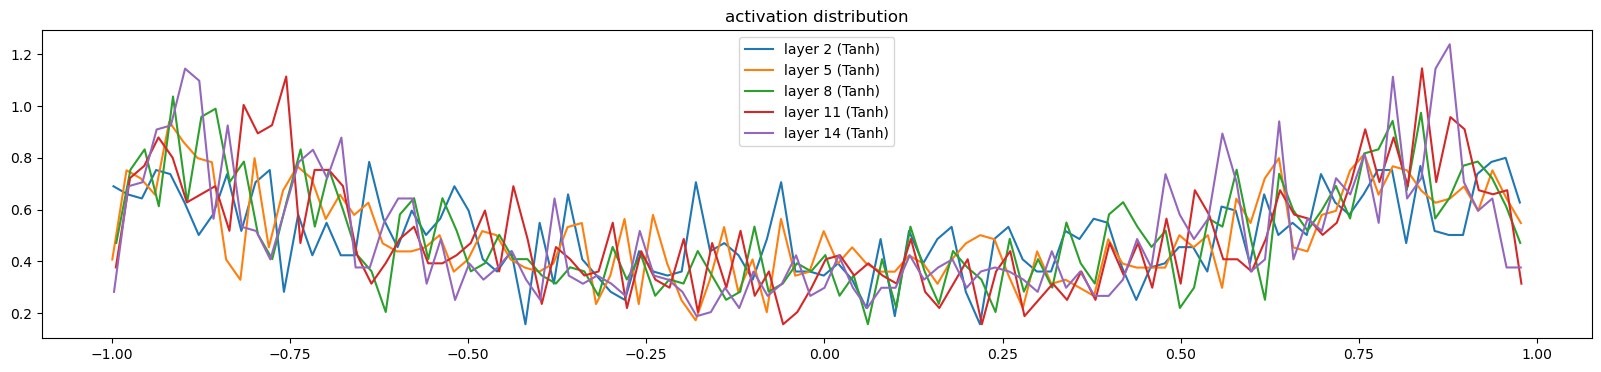

In [38]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = [] 
for i, layer in enumerate(Layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s) : mean%+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh) : mean-0.00, std 0.00, saturated 0.00%
layer 5 (      Tanh) : mean-0.00, std 0.00, saturated 0.00%
layer 8 (      Tanh) : mean-0.00, std 0.00, saturated 0.00%
layer 11 (      Tanh) : mean-0.00, std 0.00, saturated 0.00%
layer 14 (      Tanh) : mean+0.00, std 0.00, saturated 0.00%


Text(0.5, 1.0, 'gradient distribution')

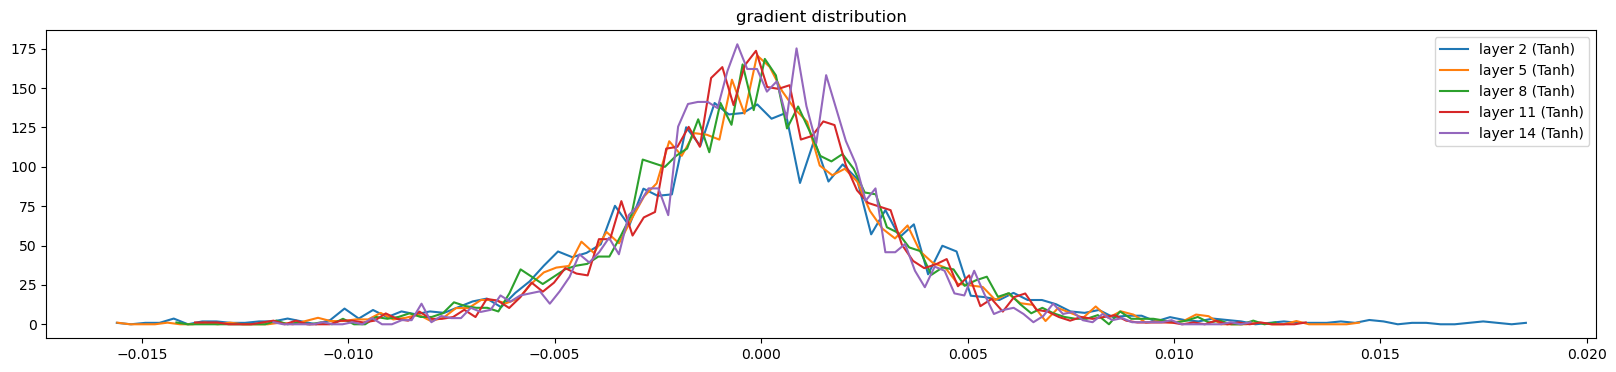

In [39]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = [] 
for i, layer in enumerate(Layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s) : mean%+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight (  (27, 10)) | mean+0.000000 | std 1.107991e-02 | grad: data ratio 1.142322e-02
weight ( (30, 100)) | mean+0.000147 | std 7.980251e-03 | grad: data ratio 2.648765e-02
weight ((100, 100)) | mean-0.000050 | std 6.926638e-03 | grad: data ratio 4.103829e-02
weight ((100, 100)) | mean+0.000077 | std 6.182675e-03 | grad: data ratio 3.672039e-02
weight ((100, 100)) | mean-0.000036 | std 6.254667e-03 | grad: data ratio 3.782225e-02
weight ((100, 100)) | mean+0.000031 | std 5.945914e-03 | grad: data ratio 3.541116e-02
weight ( (100, 27)) | mean-0.000142 | std 1.168646e-02 | grad: data ratio 7.178999e-02


Text(0.5, 1.0, 'weight gradient distribution')

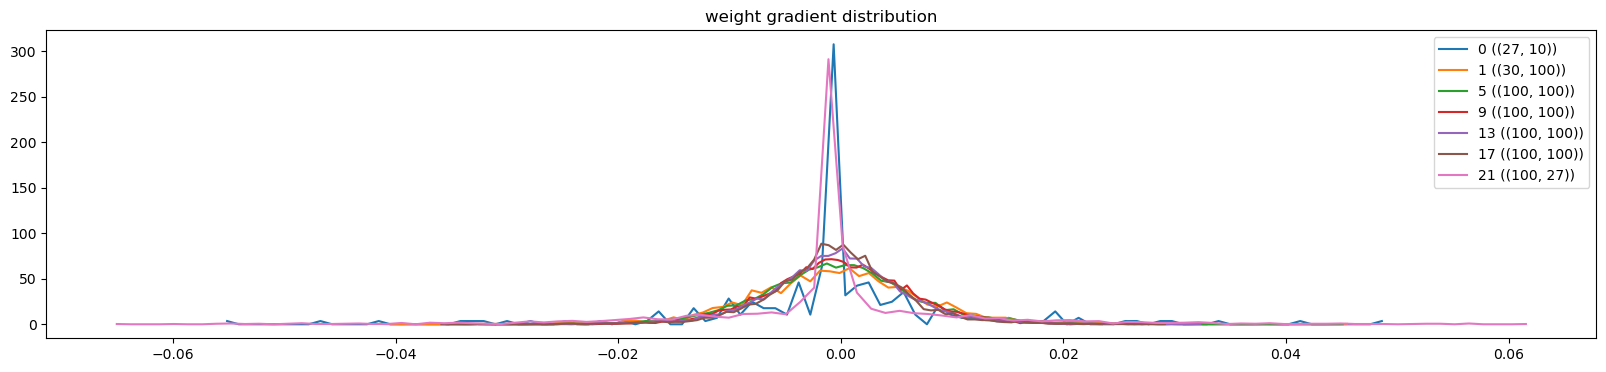

In [40]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = [] 
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight (%10s) | mean%+f | std %e | grad: data ratio %e' % (tuple(p.shape), t.mean(), t.std(),  t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) 
        legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends)
plt.title('weight gradient distribution')

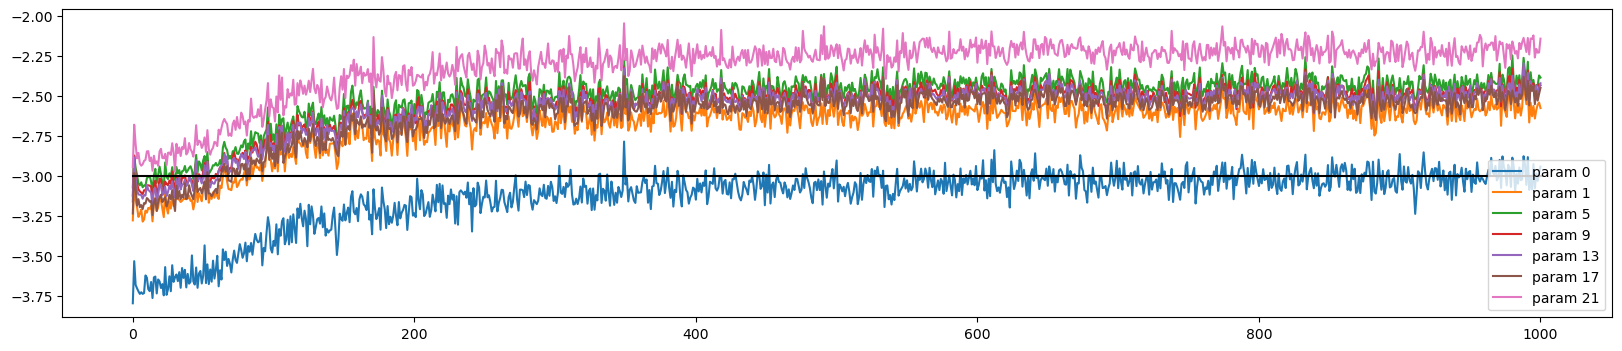

In [41]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))]) 
        legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3
plt.legend(legends) 